In [ ]:
'''
Okay the plan;



1. We predict with sahi on the whole ortho image using different parameters (overlap, slice sizing) 
3. export each prediction as a seperate folder / yolo file format
2. We tile each prediction result image and bounding boxes into smaller images
    - this would basically be a dataset of original sized tile images along with a corresponding labels folder and a YAML file
3. randomly select 10% of images and label them in labelstudio
4. use fiftyone merge datasets to merge predict output tiles and labels with labelstudio groundtruth label and tiles
5. evaluate model performace and adjust confidence intervals
6. georef and make figures using the best whole image predictions




'''

In [37]:
# first check the wd
# this should be AIggregation folder, change if its not

import os
print("cwd is:", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())


'/home/tmueller/github/AIggregation'

 100% |█████████████████████| 1/1 [14.3ms elapsed, 0s remaining, 80.3 samples/s] 


09/12/2024 09:39:42 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [14.3ms elapsed, 0s remaining, 80.3 samples/s] 



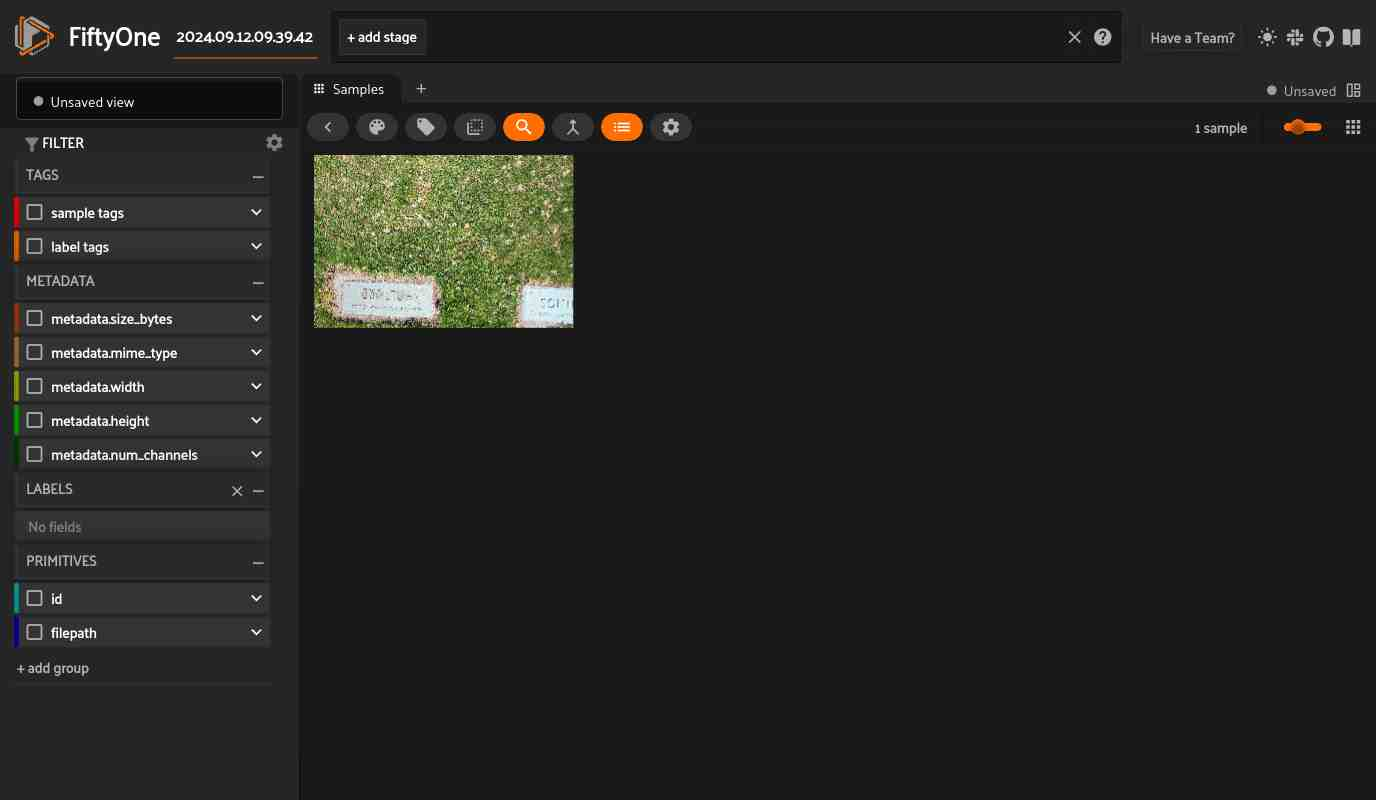

In [12]:

# import fiftyone
import fiftyone as fo
from fiftyone import ViewField as F


# Import ortho image into fiftyone dataset type
dataset = fo.Dataset.from_images(
    ["datasets/test.JPG"]
)




# open test image instance to verify it loaded correctly
session = fo.launch_app(dataset)

In [13]:
# import sahi 
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction


# specify AI detection model
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path='AIggregation_yolov5m/weights/best.pt', #specify path to trained model
    confidence_threshold=0.25,
    device="cpu", # or 'cuda:0'
)


 100% |█████████████████████| 1/1 [1.5m elapsed, 0s remaining, 0.0 samples/s] 


09/12/2024 09:41:20 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.5m elapsed, 0s remaining, 0.0 samples/s] 



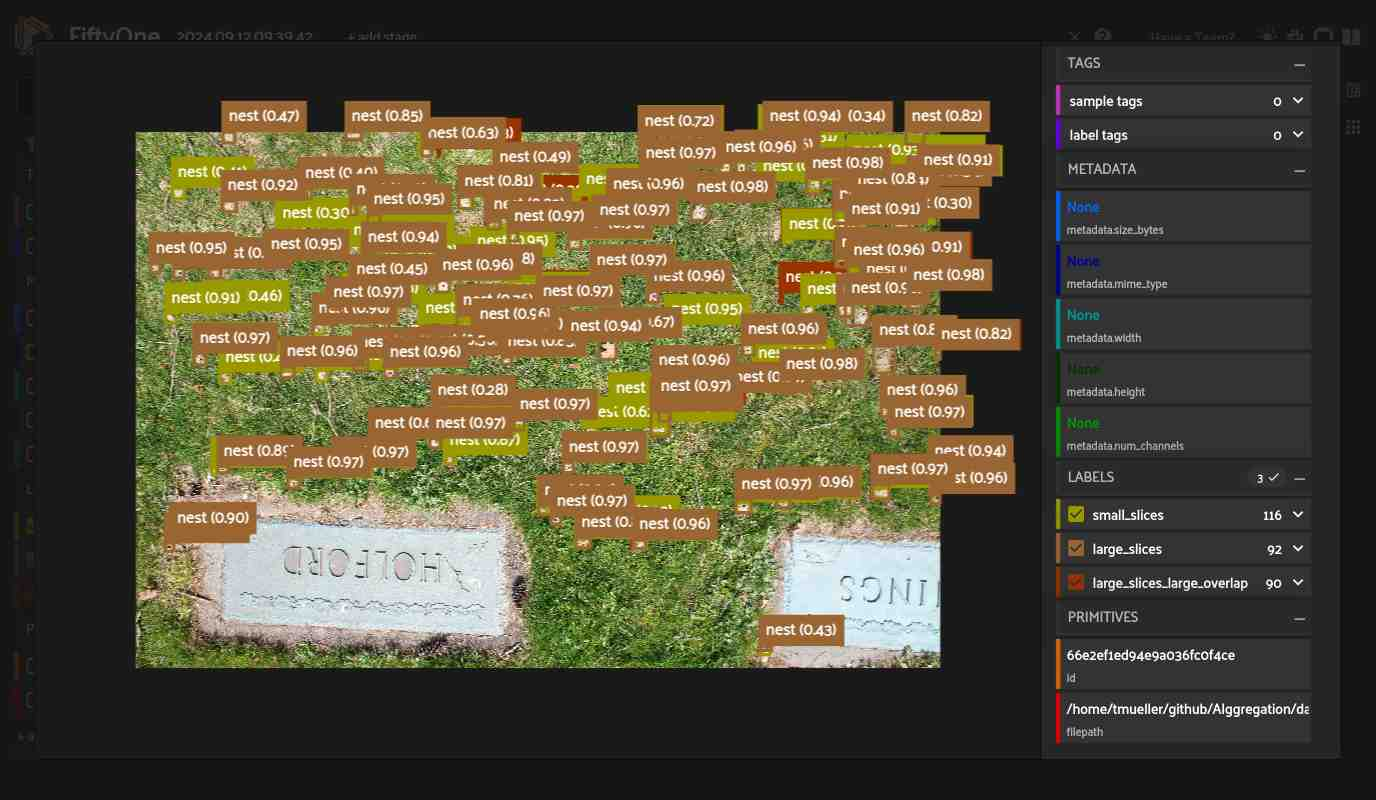

In [14]:


# Run and compare different slicing parameters
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())


#kwargs if you want to specify many arguments that are the same for all models
#kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}

kwargs = {}


for sample in dataset.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample,
                         label_field="small_slices",
                         slice_height=304,
                         slice_width=304,overlap_height_ratio = .2,
                         overlap_width_ratio=.2,
                         **kwargs
    )
    predict_with_slicing(sample,
                         label_field="large_slices",
                         slice_height=608, slice_width=608,
                         overlap_height_ratio = .2, overlap_width_ratio=.2,
                         **kwargs
    )
    predict_with_slicing(sample,
                         label_field="large_slices_large_overlap",
                         slice_height=608, slice_width=608,
                         overlap_height_ratio = .4, overlap_width_ratio=.4,
                         **kwargs
    )


#bring up new session to see boxes
session.show()



In [20]:
# export the 3 different sahi predictions and save them



# first specify directories and which bounding boxes (labels) to export to each dir
# this will create those dir but fail if they already exist

small_dir = "datasets/export_test/small_slices"
small_label = "small_slices"  

large_dir = "datasets/export_test/large_slices"
large_label = "large_slices"  

largelarge_dir = "datasets/export_test/large_slices_large_overlap"
largelarge_label = "large_slices_large_overlap"  


#export small slice
dataset.export(
        export_dir=small_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=small_label
    )

#export large slice
dataset.export(
        export_dir=large_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=large_label
    )


#export large slice large overlap
dataset.export(
        export_dir=largelarge_dir,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field=largelarge_label
    )





 100% |█████████████████████| 1/1 [91.5ms elapsed, 0s remaining, 10.9 samples/s] 


09/12/2024 09:50:13 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [91.5ms elapsed, 0s remaining, 10.9 samples/s] 


 100% |█████████████████████| 1/1 [53.5ms elapsed, 0s remaining, 18.7 samples/s] 


09/12/2024 09:50:13 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [53.5ms elapsed, 0s remaining, 18.7 samples/s] 


 100% |█████████████████████| 1/1 [53.3ms elapsed, 0s remaining, 18.7 samples/s] 


09/12/2024 09:50:13 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [53.3ms elapsed, 0s remaining, 18.7 samples/s] 


In [51]:
# rearrange files to all be together before tiling

import os, shutil


# create a loop that goes through the 3 folders
directory = "datasets/export_test/"

filelist = []

# walk through folders and make a copy of JPGS and txt up 2 directories
for root, dirs, files in os.walk(directory):
    for file in files:
        filelist.append(os.path.join(root,file))
        for jpgtxtFile in filelist:
            if jpgtxtFile.endswith((".JPG", ".txt")):
                shutil.copy(jpgtxtFile, "/".join(list(jpgtxtFile.split('/')[0:-3])) )  # this splits the jpgtxt path at / and drops the last 3 parts (up 2 dir)



In [56]:
# tile the image and outputs


''' 
the exported sahi prediction can now be tiled. 

The below script takes a folder containing identically named image and txt files and tiles them into a new folder. 
This was written for yolov4 format which is slightly different but works for this itll just warn of no Class file and output all files into a single folder

'''


# run yolo_tile script
%run scripts/yolo_tile.py -source ./datasets/export_test/large_slices -target ./datasets/tiled_export/tile_test/large_slices -ext .JPG -size 608 -ratio 0.8
%run scripts/yolo_tile.py -source ./datasets/export_test/small_slices -target ./datasets/tiled_export/tile_test/small_slices -ext .JPG -size 608 -ratio 0.8
%run scripts/yolo_tile.py -source ./datasets/export_test/large_slices_large_overlap -target ./datasets/tiled_export/tile_test/large_slices_large_overlap -ext .JPG -size 608 -ratio 0.8




# the ratio creates txt files listing a random list of the tiles  in each set (test/train)

'''
    PARAMETERS:

    -source         Source folder with images and labels needed to be tiled. Default: ./yolosample/ts/
    -target         Target folder for a new sliced dataset. Default: ./yolosliced/ts/
    -ext            Image extension in a dataset. Default: .JPG
    -falsefolder    Folder for tiles without bounding boxes
    -size           Size of a tile. Default: 416
    -ratio          Train/test split ratio. Dafault: 0.8 (i.e. 80% in train)
'''

classes.names not found. It should be located one level higher than images
Image: ./datasets/export_test/large_slices/test.JPG
./datasets/tiled_export/tile_test/large_slices/test_0_0.JPG
   class        x1        y1         w         h
0      0  0.980466  0.831702  0.035778  0.120054
1      0  0.987295  0.061278  0.022121  0.122556
./datasets/tiled_export/tile_test/large_slices/test_0_1.JPG
   class        x1        y1         w         h
0      0  0.064710  0.831702  0.129419  0.120054
1      0  0.051977  0.061278  0.103954  0.122556
2      0  0.897398  0.691548  0.133308  0.111126
./datasets/tiled_export/tile_test/large_slices/test_0_2.JPG
   class        x1        y1         w         h
0      0  0.663613  0.962949  0.135747  0.070812
1      0  0.436930  0.040602  0.172368  0.080376
2      0  0.436966  0.873186  0.067878  0.113052
./datasets/tiled_export/tile_test/large_slices/test_0_3.JPG
   class        x1        y1         w         h
0      0  0.969235  0.988514  0.058241  0.019

'\n    PARAMETERS:\n\n    -source         Source folder with images and labels needed to be tiled. Default: ./yolosample/ts/\n    -target         Target folder for a new sliced dataset. Default: ./yolosliced/ts/\n    -ext            Image extension in a dataset. Default: .JPG\n    -falsefolder    Folder for tiles without bounding boxes\n    -size           Size of a tile. Default: 416\n    -ratio          Train/test split ratio. Dafault: 0.8\n'

In [113]:
# write a yaml file for each folder

import yaml

directory = "datasets/tiled_export/tile_test/"

filelist = []

folder = ["large_slices_large_overlap", "large_slices", "small_slices"]


for f in folder:
    data = {
        'names':{
        0: "nest"},
        'path': os.path.join("..", f),
        'val': "./images/"
            }
    with open((os.path.join(directory, f,"data.yaml")), 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False, sort_keys=False)





# create new images and labels folders
import os
names = ("images","labels")
pathlist = []



for f in folder:
    path= os.path.join(directory,f)
    pathlist.append(os.path.join(path))


for name in names:
    for p in pathlist:
        newpath = (os.path.join(p, name))
        if not os.path.exists(newpath):
            os.makedirs(newpath)
            print("folder created:", newpath)



folder created: datasets/tiled_export/tile_test/large_slices_large_overlap/images
folder created: datasets/tiled_export/tile_test/large_slices/images
folder created: datasets/tiled_export/tile_test/small_slices/images
folder created: datasets/tiled_export/tile_test/large_slices_large_overlap/labels
folder created: datasets/tiled_export/tile_test/large_slices/labels
folder created: datasets/tiled_export/tile_test/small_slices/labels


In [118]:
# copies txt and image files that are in the testlist.txt file back into yolo5 format

path = 'datasets/tiled_export/tile_test/testlist.txt'

import os 
import shutil

directory = "datasets/tiled_export/tile_test/"
tilelist = []
folder = ["large_slices_large_overlap", "large_slices", "small_slices"]

testpath = 'datasets/tiled_export/tile_test/testlist.txt'
with open(testpath, 'r') as fp:
    testlist = fp.read().splitlines()



for f in folder:
    for item in testlist:
            if item.endswith(".JPG"):
                shutil.copy(item, os.path.join(directory,f, "images"))
            elif item.endswith(".txt"):
                shutil.copy(item, os.path.join(directory,f, "labels"))
    



In [104]:
'''
reimport as individual fiftyone files

then merge files with different labels

THIS NEEDS AN ANNOTATED DATASET OF GROUND TRUTHS

'''

#then import in fiftyone

import fiftyone as fo
import fiftyone.utils.yolo as fouy


# Import annotated datasets by labels
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tile_test/small_slices/data.yaml",
    label_field= "small_slices"
)


dataset2 = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tile_test/large_slices/data.yaml",
    label_field= "large_slices"
)

dataset3 = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = "datasets/tiled_export/tile_test/large_slices_large_overlap/data.yaml",
    label_field= "large_slices_large_overlap"
)



# now merge the datasets, ignoring that they have different directory and merging images/labels with the same file name

key_fcn = lambda sample: os.path.basename(sample.filepath)

dataset2.merge_samples(dataset3, key_fcn=key_fcn)
dataset.merge_samples(dataset2, key_fcn=key_fcn)

# view that this worked
session = fo.launch_app(dataset)





 100% |███████████████████| 42/42 [96.3ms elapsed, 0s remaining, 436.1 samples/s]  
 100% |███████████████████| 42/42 [75.7ms elapsed, 0s remaining, 554.9 samples/s]     
 100% |███████████████████| 42/42 [66.2ms elapsed, 0s remaining, 634.8 samples/s]     
Indexing dataset...
 100% |███████████████████| 42/42 [21.6ms elapsed, 0s remaining, 1.9K samples/s] 
Merging samples...
 42 [123.4ms elapsed, ? remaining, 344.5 samples/s] 
Indexing dataset...
 100% |███████████████████| 42/42 [27.0ms elapsed, 0s remaining, 1.6K samples/s] 
Merging samples...
 42 [176.0ms elapsed, ? remaining, 241.0 samples/s] 


In [ ]:

# evaluate 

# THIS NEEDS TO BE WRITTEN

'''


# evaluate the different sahi predictions
large_slice_results = dataset.evaluate_detections("large_slices", gt_field="ground_truth", eval_key="eval_large_slices")
small_slice_results = dataset.evaluate_detections("small_slices", gt_field="ground_truth", eval_key="eval_small_slices")
overlap_slice_results = dataset.evaluate_detections("large_slices_overlap", gt_field="ground_truth", eval_key="eval_large_slices_overlap")

# print eval results
print("-" * 50)
print("Large slice results:")
large_slice_results.print_report()

print("-" * 50)
print("Large slice overlap results:")
overlap_slice_results.print_report()

print("-" * 50)
print("Small slice results:")
small_slice_results.print_report()

'''